# Solving Image Maze (With Solution)

Given a maze as an image with a start and end point, we would like to write code to solve the maze. 

An image is a 2D matrix of pixels of a particular size that depends on its resolution. Each 
pixel has a color which is given by its Red, Green and Blue (RGB) values.
 
Given an image, we will view it as a graph where each pixel of the image is a vertex 
and edges connect a pixel to its neighbor. The weight of an edge should be very small if
the pixel colors are similar (i.e, the differences between r, g and b values are close to zero)
and correspondingly large as the pixel colors diverge.
  
Next, given a source pixel $(i_0, j_0)$ and destination pixel, 
$(i_1, j_1)$, we wish find the shortest weight path from source to destination.

You should use the Dijkstra's algorithm modified in two ways:
   - It can exit as soon as the destination is reached.
   - A 1000 x 1000 pixel image gives rise to a graph with million vertices. Storing such a graph as an adjacency list is going to be very memory intensive. Instead, your goal will be to generate the vertices and edges *on-the-fly*.
   
We will use opencv library, a popular computer vision library to load, and manipulate images of mazes.



## Manipulating Images

You can directly manipulate images in python in many ways. The `opencv` library is considered a standard for numerous
image manipulation tasks.

Here we load an image `maze.png` and you can see it nicely plotted with coordinates. We then show you two pixels
shown in red and blue. The goal here is to detect a path from one of the colored circle to the other, in the maze without crossing
the black pixels.

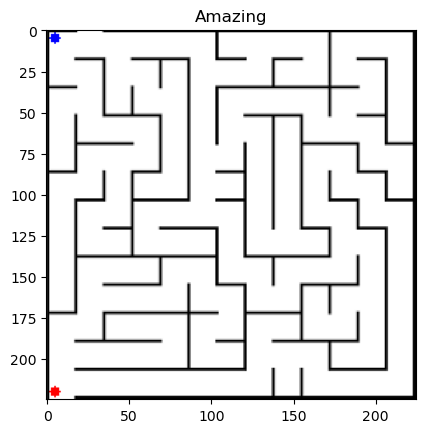

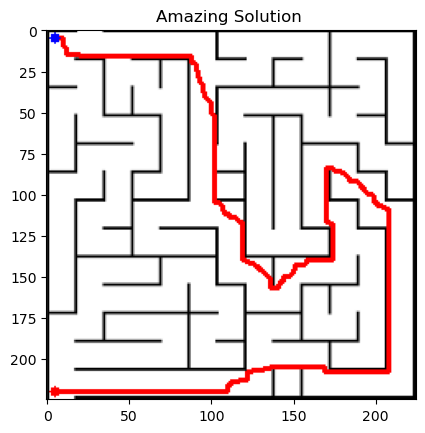

In [21]:
from matplotlib import pyplot as plt
import cv2
# You can read png, jpg and other file types 
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()
img = cv2.imread('maze-solution.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing Solution ')
plt.show()


Given an image it is simple to read the color at a pixel. Let us read the color at pixel (645, 67)

In [22]:
print('Image size (height, width, num layers) is', img.shape)
px = img[145, 67] # img[y,x] is the color of the pixel of x,y
print(px) 
cv2.circle(img, (80, 18), 3, (198,31,4),-1) # Draw a colored circle centered at (80, 18)
px1 = img[18, 80] # It is important to note that rows of the image are y values and columns are x values.
print(px1)
px2 = img[80, 18] # This is important to note that indexing the img data structure takes y, x values.
# Most opencv functions will require (x,y) coordinates for pixel as is natural.
print(px2)

Image size (height, width, num layers) is (225, 225, 3)
[255 255 255]
[198  31   4]
[0 0 0]


The pixel color is expressed in RGB format. R is the red value from 0 -> 255, G is the green value 0 -> 255 and B is the blue value from 0 -> 255 

We will now define a edge weight function for an edge in the image

In [23]:
import math 
def fixPixelValues(px):
    # convert the RGB values into floating point to avoid an overflow that will give me wrong answers
    return [ float(px[0]), float(px[1]), float(px[2]) ]


    
# This is a useful function that given a list of (x,y) values, 
# draw a series of red lines between each coordinate and next to 
# show the path in the image
def drawPath(img, path, pThick=2):
    v = path[0]
    x0, y0 = v[0], v[1]
    for v in path:
        x, y = v[0], v[1]
        cv2.line(img,(x,y), (x0,y0), (255,0,0),pThick)
        x0, y0 = x,y
        

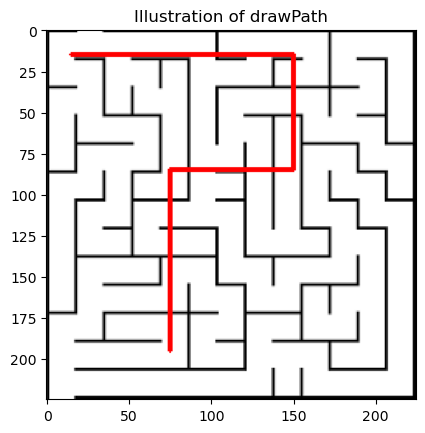

In [24]:
# Example
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
drawPath(img, [ (15, 15), (150, 15), (150, 85), (75, 85), (75, 195)])
plt.imshow(img) # show the image on the screen 
plt.title('Illustration of drawPath')
plt.show()

## Step 1: Compute Single Source Shortest Path For an Image

Given an image, compute the  shortest path between source and destination pixels by modifying Dijkstra's algorithm. __Your challenge  is to implement it without needing to create the entire the adjacency list for the graph
in the first place. However, for simplicity you can try a first cut implementation of a generic Dijkstra algorithm over
graphs represented as adjacency matrix or list.__ 

In [25]:
class Vertex: # This is the outline for a vertex data structure
    
    def __init__ (self,  i, j):
        self.x = i # The x coordinate
        self.y = j  # The y coordinate
        self.d = float('inf') # the shortest path estimate
        self.processed = False # Has this vertex's final shortest path distance been computed
        # this is important for Dijksatra's algorithm
        # We will track where the vertex is in the priority queue.
        self.idx_in_priority_queue = -1 # The index of this vertex in the queue
        self.pi = None # the parent vertex in the shortest path tree.
        
    def reset(self):
        self.d = float('inf')
        self.processed = False # Has this vertex's final shortest path distance been computed
        # this is important for Dijksatra's algorithm
        # We will track where the vertex is in the priority queue.
        self.idx_in_priority_queue = -1 # The index of this vertex in the queue
        self.pi = None # the parent vertex in the shortest path tree.
    

# However, if you want Dijkstra efficiently, we will need a priority queue
# We will provide you with a heap data structure from course 1.
class PriorityQueue:
    # Constructor:  Implement a empty heap data structure
    def __init__(self):
        self.q = [None] # pad it with one element
    
    # Function: insert
    # Insert a vertex v of type Vertex into the queue.
    # Remember to set the field `idx_in_priority_queue` and
    # keep updating it.
    def insert(self, v):
        n = len(self.q)
        self.q.append(v)
        v.idx_in_priority_queue = n
        self.bubble_up(n)
        # self.check_invariant()
        
    # Function: swap two elements in the priority queue.
    # Remember to swap the vertices at positions i and j
    # But also remember to update the positions of the vertices in the
    # priority queue.
    # You can use this to implement bubble_up and bubble_down
    def swap(self, i, j):
        tmp = self.q[i]
        self.q[i] = self.q[j]
        self.q[i].idx_in_priority_queue = i
        self.q[j] = tmp
        self.q[j].idx_in_priority_queue = j
        
    # Function: bubble_up
    # bubble up an element j
    # until min heap property is restored.
    def bubble_up(self, j):
        assert j >= 1
        assert j < len(self.q)
        if j == 1:
            return
        val = self.q[j].d
        parent_idx = j // 2
        parent_val = self.q[parent_idx].d
        if val < parent_val:
            self.swap(j, parent_idx)
            self.bubble_up(parent_idx)
        return
    
    # Function: bubble_down
    # Bubble down an element j until
    # min heap property is restored.
    def bubble_down(self, j):
        n = len(self.q)
        left_child_idx = 2 * j
        right_child_idx = 2 * j + 1
        if left_child_idx >= n:
            return
        if right_child_idx >= n:
            child_idx = left_child_idx
            child_d = self.q[left_child_idx].d
        else:
            (child_d, child_idx) = min ( (self.q[left_child_idx].d, left_child_idx), 
                                         (self.q[right_child_idx].d, right_child_idx)
                                       )
        if self.q[j].d > child_d:
            self.swap(j, child_idx)
            self.bubble_down(child_idx)
        return 
        
    # Function: get_and_delete_min
    # Find the minimum weight vertex and delete it from the heap.
    # return the deleted vertex back
    def get_and_delete_min(self):
        n = len(self.q)
        assert n > 1
        v = self.q[1]
        if n > 2: 
            self.q[1] = self.q[n-1]
            self.q[n-1].idx_in_priority_queue = 1
            del self.q[n-1]
            self.bubble_down(1)
        #self.check_invariant()
        return v
    
    # Is the heap empty?
    def is_empty(self):
        return len(self.q) == 1
    
    # This is a useful function since in Dijkstra
    # the weight of a vertex updates on the fly.
    # We will need to call this to update the vertex weight.
    def update_vertex_weight(self, v):
        j = v.idx_in_priority_queue
        n = len(self.q)
        assert j >= 0 and j < n
        self.bubble_down(j)
        self.bubble_up(j)
        # self.check_invariant()
        
   

In [26]:
class DirectedGraphFromImage:
    def __init__(self, img):
        self.img = img
        self.coords2vertex = {} # construct a dictionary that maps coordinates [(i,j)] to corresponding vertices in graph
    
        
    def get_vertex_from_coords(self, i, j):
        if (i,j) in self.coords2vertex: # is pixel (i,j) already there? 
            return self.coords2vertex[(i,j)] # if yes, just return the vertex corresponding
        v = Vertex(i, j)
        self.coords2vertex[(i,j)] = v
        return v
    
    ## Given (x,y) coordinates of two neighboring pixels, calculate the edge weight.
    # We take the squared euclidean distance between the pixel values and add 0.1
    def getEdgeWeight(self, u, v):
        img = self.img
        # get edge weight for edge between u, v
        i0,j0 = u.x, u.y
        i1,j1 = v.x, v.y
        height, width, _ = img.shape
        # First make sure that the edge is legit
        # Edges can only go from each pixel to neighboring pixel
        assert i0 >= 0 and j0 >= 0 and i0 < width and j0 < height # pixel position valid?
        assert i1 >= 0 and j1 >= 0 and i1 < width and j1 < height # pixel position valid?
        assert -1 <= i0 - i1 <= 1 # edge between node and neighbor?
        assert -1 <= j0 - j1 <= 1
        px1 = fixPixelValues(img[j0,i0])
        px2 = fixPixelValues(img[j1,i1])
        return 0.1 + (px1[0] - px2[0])**2 + (px1[1] - px2[1])**2 + (px1[2]- px2[2])**2

    # Function: get_list_of_neighbors
    # Given a vertex in the graph, get its list of neighbors
    #  I.e, for given vertex `vert` return a list [(v1, w1), (v2, w2),..,(vk,wk)]
    #  Such that vert has an edge to v1 with weight w1, edge to v2 with weight w2 and ... 
    #   edge to vk with weight wk
    # Note that rather than build an adjacency list up front, we simply call this function
    # to get the neighbors of a vertex.
    def get_list_of_neighbors(self, vert):
        img = self.img
        i = vert.x
        j = vert.y
        height, width, _ = img.shape
        lst = []
        if i > 0:
             # Get the adjacent vertex directly to the WEST
            # What is the weight of the edge from pixel (i,j) to (i-1,j)
            v0 = self.get_vertex_from_coords(i-1, j)
            w0 = self.getEdgeWeight(vert, v0)
            # Append the adjacent vertex and its weight.
            lst.append((v0, w0))
        if j > 0:
            # Get the adjacent vertex directly to the SOUTH
            v1 = self.get_vertex_from_coords(i, j-1)
            w1 = self.getEdgeWeight(vert, v1)
            # Append the adjacent vertex and its weight.
            lst.append((v1, w1))    
        if i < width-1:
            # EAST
            v2 = self.get_vertex_from_coords(i+1, j)
            w2 = self.getEdgeWeight( vert, v2)
            lst.append((v2, w2))
        if j < height-1:
            # NORTH
            v3 = self.get_vertex_from_coords(i, j+1)
            w3 = self.getEdgeWeight(vert, v3)
            lst.append((v3, w3))
        return lst


Using Dijkstra's algorithm and the classes provided above, implement the function
`computeShortestPath`. Its inputs are
  - `graph` : an instance of DirectedGraphFromImage class
  - `source_coordinates`: The (i,j) coordinates of the starting point.
  - `dest_coordinates`: The (i,j) coordinates of the destination. 
  
It must return a tuple `(path, distance)` wherein 
  - `path` is a list of pixel coordinates `[(i0,j0),...., (ik,jk)]` wherein `(i0,j0)` corresponds to the `soure_coordinates` and `(ik,jk))` corresponds to the destination.
  - `distance` is the total weight of the shortest path.
  
 ## Pseudocode 
 Here is an outline of Dijkstra's algorithm with modifications that may be useful.
 
 ~~~
 1. Initialize an empty priority queue `q` (use `PriorityQueue` class)
 2. Get the source vertex (`source`) using the function `graph.get_vertex_from_coords(i,j)`.
 3. Set the `source.d` field to 0 to indicate that distance of source from source is 0.
 4. Add the source vertex to the priority queue (use `insert` method).
 5. While the priority queue is not empty.
    5.1 Get the vertex with minimum value of d and delete it (use `get_and_delete_min` function). Let's call this vertex `u`.
    5.2 Set the processed field of `u` to True.
    5.3 If `u` has the same coordinates as destination (use `u.x` and `u.y`) then 
        5.3.1 shortest path distance is `u.d` and break from the loop.
    5.4 For each outgoing edge from `u` to `v` with weight `w`
        5.4.1 If `v` is not already processed and `v.d > u.d + w` then 
              5.4.1.1 update `v.d` to `u.d + w`. Set `v.pi` to `u`.
              5.4.1.2 If `v` is already not in the priority queue, insert it into the queue
              5.4.1.3 Else, use the `update_vertex_weight` method of priority queue with `v` as the argument to make sure that `v` is moved to the appropriate place in the priority queue.
 6. To get the path, start from the destination vertex and keep taking the parent pointer until we reach the source. Store the sequence of vertices in a path.
 7. Return the (path, shortest path distance)
 ~~~
 

In [40]:
# Function: computeShortestPath
# Let us implement Dijkstra's algorithm
# graph - instance of the DirectedGraphFromImage class
# source - a vertex that is the source (i,j) pixel coordinates
# dest - a vertex that is the destination (i,j) pixel coordinates
def computeShortestPath( graph, source_coordinates, dest_coordinates):
    # your code here
    source = graph.get_vertex_from_coords(*source_coordinates)
    #print(source)
    dest = graph.get_vertex_from_coords(*dest_coordinates)
    #print(dest)    
    # Initialize an empty priority queue
    q = PriorityQueue()
        
    # Set the source vertex distance to 0
    source.d = 0
        
    # Insert the source vertex into the priority queue
    q.insert(source)
        
    while not q.is_empty():
        # Get the vertex with the minimum distance from the priority queue
        u = q.get_and_delete_min()
            
        # Mark the vertex as processed
        u.processed = True
            
        # If the destination vertex is reached, break from the loop
        if u.x == dest.x and u.y == dest.y:
            break
            
        # Get the list of neighbors of the current vertex
        neighbors = graph.get_list_of_neighbors(u)
        # print(neighbors)
        # Relax the edges of the current vertex
        for v, w in neighbors:
            if not v.processed and v.d > u.d + w:
                # Update the distance of the neighbor vertex
                v.d = u.d + w
                
                # Set the parent of the neighbor vertex
                v.pi = u
                    
                if v.idx_in_priority_queue == -1:
                    # If the neighbor vertex is not in the priority queue, insert it
                    q.insert(v)
                else:
                    # If the neighbor vertex is already in the priority queue, update its weight
                    q.update_vertex_weight(v)
        
    # Get the path from the destination vertex to the source vertex
    path = []
    current = dest
    while current is not None:
        path.append((current.x, current.y))
        current = current.pi
    path.reverse()
        
    # Return the path and the shortest path distance
    return path, dest.d
    

In [41]:
class DummyGraphClass:
    def __init__(self, adj_list, verts):
        self.verts=verts
        self.adj_list = adj_list
        
                
    def get_vertex_from_coords(self, i, j):
        assert (i,j) in self.verts
        return self.verts[(i,j)]
    
    def get_list_of_neighbors(self, vert):
        coords = (vert.x, vert.y)
        if coords in self.adj_list:
            return self.adj_list[(vert.x, vert.y)]
        else:
            return []
    
# Test 1
verts = {(i,j): Vertex(i,j) for i in range(3) for j in range(3)}
adj_list= {}
def connect_nodes(src, dest, weight):
    v1 = src
    v2 = verts[dest]
    if v1 in adj_list:
        adj_list[v1].append((v2, weight))
    else:
        adj_list[v1] = [(v2, weight)]
# Let's build a graph
connect_nodes((0,0),(0,1),1.0)
connect_nodes((0,0),(1,0),0.5)
connect_nodes((1,0),(0,1), 0.5)
connect_nodes((0,1),(0,0), 0.5)
connect_nodes((1,0),(1,1), 0.5)
connect_nodes((1,1), (2,2), 0.25)
connect_nodes((1,1),(1,2), 0.5)
connect_nodes((1,1),(2,1), 1.2)
connect_nodes((2,1), (2,2), 0.25)
connect_nodes((1,2), (2,2), 0.25)

graph = DummyGraphClass(adj_list, verts)

path, dist = computeShortestPath(graph, (0,0), (2,2))
print(path)

assert(dist == 1.25) , ' shortest path distance from (0,0) to (2,2) must be 1.25'
assert (path == [(0,0), (1,0), (1,1), (2,2)])

for (_,v) in verts.items():
    v.reset()

graph2 = DummyGraphClass(adj_list, verts)
(path2, dist2) = computeShortestPath(graph2, (0,0),(1,2))
print(path2)
assert dist2 == 1.5, ' shortest path distance from (0,0) to (1,2) must be 1.5'
assert path2[0] == (0,0)
assert path2[-1] == (1,2)

for (_,v) in verts.items():
    v.reset()

connect_nodes((2,2), (2,1), 0.5)
connect_nodes((2,1), (1,1), 1.0)
connect_nodes((1,1),(0,1), 0.5)


graph3 = DummyGraphClass(adj_list, verts)
(path3, dist3) = computeShortestPath(graph3, (2,2),(0,0))
print(path3)
assert(dist3 == 2.5)
assert(path3[0]== (2,2))
assert(path3[-1] == (0,0))

print('All tests passed: 15 points!')

[(0, 0), (1, 0), (1, 1), (2, 2)]
[(0, 0), (1, 0), (1, 1), (1, 2)]
[(2, 2), (2, 1), (1, 1), (0, 1), (0, 0)]
All tests passed: 15 points!


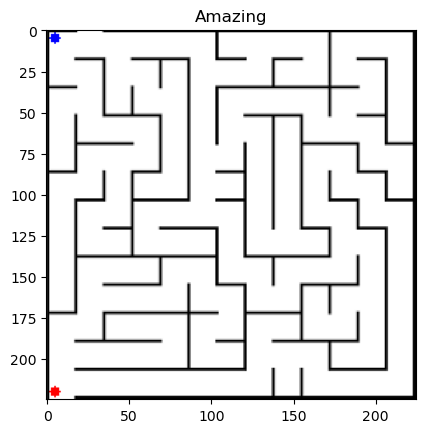

In [29]:
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
# you can annotate images 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle centered at (5, 220) radius 3, color red (RGB: 255,0,0)
cv2.circle(img, (5,5), 3, (0,0,255), -1) # add a circle centered at (5,5) radius 3, color red (RGB: 0,0,255)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()

In [42]:
img = cv2.imread('maze.png') # read an image from a file using opencv (cv2) library
graph = DirectedGraphFromImage(img)
p,dist = computeShortestPath(graph, (5,220), (5,5))
assert dist <= 78.1, 'Expected shortest path distance must be 78.1'
assert p[0] == (5,220)
assert p[-1] == (5,5)
print('Passed: 10 points!')

Passed: 10 points!


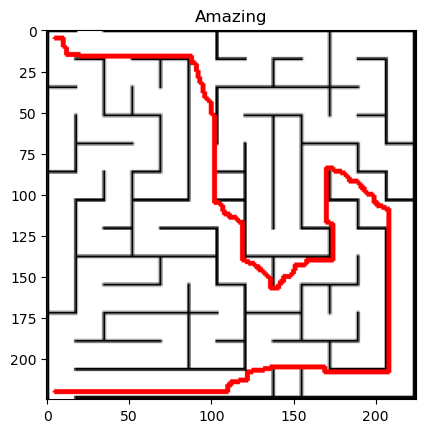

True

In [43]:
drawPath(img, p, 2)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing')
plt.show()
cv2.imwrite('maze-solution.png', img)

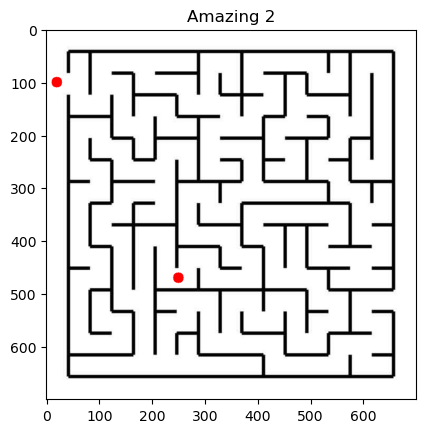

In [44]:
img = cv2.imread('maze2.JPG') # read an image from a file using opencv (cv2) library
cv2.circle(img,(250,470), 10, (255,0,0), -1) # add a circle centered at (600, 70) radius 10, color red (RGB: 255,0,0)
cv2.circle(img, (20,100), 10, (255,0,0), -1) # add a circle centered at (790,200) radius 10, color red (RGB: 255,0,0)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 2')
plt.show()

In [45]:
img = cv2.imread('maze2.JPG') # read an image from a file using opencv (cv2) library
p, dist = computeShortestPath(DirectedGraphFromImage(img), (250,470), (20,100))
assert dist <= 120.0
assert p[0] == (250, 470)
assert p[-1] == (20,100)
print('Passed: 10 points!')

Passed: 10 points!


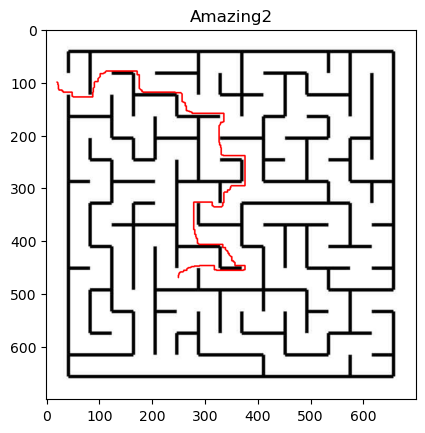

In [34]:
drawPath(img,p)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing2')
plt.show()

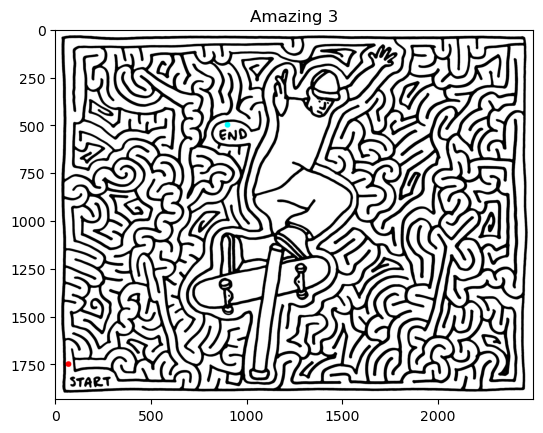

In [46]:
img = cv2.imread('maze3.JPG')
cv2.circle(img,(70,1750), 15, (255,0,0), -1) # add a circle centered at (600, 70) radius 10, color red (RGB: 255,0,0)
cv2.circle(img, (900,500), 15, (0,255,255), -1) # add a circle centered at (790,200) radius 10, color red (RGB: 255,0,0)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing 3')
plt.show()

This will take a while to run: cut and paste the code into a new code cell if you wish to try
~~~
img = cv2.imread('maze3.JPG') # read an image from a file using opencv (cv2) library
p,dist = computeShortestPath(DirectedGraphFromImage(img), (70,1750), (900,500))
~~~

In [47]:
img = cv2.imread('maze3.JPG') # read an image from a file using opencv (cv2) library
p,dist = computeShortestPath(DirectedGraphFromImage(img), (70,1750), (900,500))

This will visualize your solution over the complicated maze.
~~~
drawPath(img,p,10)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing2 Solution')
plt.show()
~~~

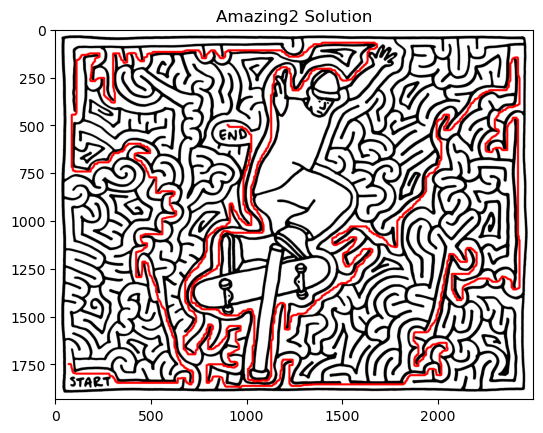

In [48]:
drawPath(img,p,10)
plt.imshow(img) # show the image on the screen 
plt.title('Amazing2 Solution')
plt.show()

## That's all Folks!